# Predicting House Prices

## Imports

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
import keras
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

## Data preprocessing

Get data as pandas array and make a dict of keras inputs

In [5]:
full_data = pd.read_csv("./Data/train.csv")
cutoff = 7 * len(full_data) // 10

#Separate training and test data
train_data = full_data[:cutoff]
features = train_data.copy()
labels = np.array(features.pop('SalePrice')) / 100000
features.pop('Id')

test_data = full_data[cutoff:]
test_features = test_data.copy()
test_labels = np.array(test_features.pop('SalePrice')) / 100000
test_features.pop('Id')

#Change the data type of the years to strings
inputs = {}
year_cols=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

for col in year_cols:
    features[col] = features[col].astype(str)
    test_features[col] = test_features[col].astype(str)

#Deal with the missing data, either with a unique name for strings or the mean of the column for numbers
for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
        features[name] = features[name].fillna('NO INFO')
    else:
        dtype = tf.float32
        features[name] = features[name].fillna(features[name].mean(axis=0))

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

test_inputs = {}

#Do the same processing for the test data
for name, column in test_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
        test_features[name] = test_features[name].fillna('NO INFO')
    else:
        dtype = tf.float32
        test_features[name] = test_features[name].fillna(test_features[name].mean(axis=0))

    test_inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

Concatenate and normalize the float/integer inputs through appropriate layers to normalize them

In [6]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

Process the string inputs, by passing through a StringLookup and CategoryEncoding layer, for one hot encoding

In [7]:
for name, inpt in inputs.items():
    if inpt.dtype == tf.float32:
        continue
    lookup = layers.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(inpt)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [8]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
preprocessing_model = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [9]:
features_dict = {name: np.array(value) 
                for name, value in features.items()}
test_features_dict = {name: np.array(value) 
                    for name, value in test_features.items()}

## Building the first model: Keras neural network

Start with a simple model, with one hidden layer of 40 nodes (more complex models were tried without much success)

In [10]:
def first_model(preprocessing, inputs):
    main = tf.keras.Sequential([
        layers.Dense(40, activation='relu'),
        layers.Dropout(.2, input_shape=(2,)),
        layers.Dense(1)
    ])
    preprocessed_inputs = preprocessing(inputs)
    result = main(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    #The loss function will be based on the mean absolute percentage error
    model.compile(loss=tf.losses.MeanSquaredLogarithmicError(),
                optimizer=tf.optimizers.Adam(),
                 metrics=['MeanAbsolutePercentageError', 'MSLE'])
    return model

Define some callbacks, to save the training and test error on each epoch

In [11]:
class Callbacks(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['mean_absolute_percentage_error'])
        epochs_list.append(epoch)
        test_losses.append(self.model.evaluate(test_features_dict, test_labels)[1])

Train the model

In [12]:
train_losses = []
test_losses = []
epochs_list = []
model = first_model(preprocessing_model, inputs)
model.fit(x=features_dict, y=labels, epochs=80, callbacks=[Callbacks()])

Epoch 1/80
32/32 [==============================] - 6s 59ms/step - loss: 0.2131 - mean_absolute_percentage_error: 46.6095 - MSLE: 0.2131
Epoch 2/80
32/32 [==============================] - 0s 12ms/step - loss: 0.0325 - mean_absolute_percentage_error: 23.6192 - MSLE: 0.0325
Epoch 3/80
32/32 [==============================] - 0s 12ms/step - loss: 0.0226 - mean_absolute_percentage_error: 19.6082 - MSLE: 0.0226
Epoch 4/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0175 - mean_absolute_percentage_error: 16.6543 - MSLE: 0.0175
Epoch 5/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0165 - mean_absolute_percentage_error: 16.2498 - MSLE: 0.0165
Epoch 6/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0143 - mean_absolute_percentage_error: 14.8413 - MSLE: 0.0143
Epoch 7/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0141 - mean_absolute_percentage_error: 14.5747 - MSLE: 0.0141
Epoch 8/80
32/32 [=======================

32/32 [==============================] - 1s 19ms/step - loss: 0.0084 - mean_absolute_percentage_error: 11.1837 - MSLE: 0.0084
Epoch 33/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0078 - mean_absolute_percentage_error: 11.2478 - MSLE: 0.0078
Epoch 34/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_absolute_percentage_error: 10.5509 - MSLE: 0.0074
Epoch 35/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_absolute_percentage_error: 10.8892 - MSLE: 0.0074
Epoch 36/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0087 - mean_absolute_percentage_error: 11.2136 - MSLE: 0.0087
Epoch 37/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0080 - mean_absolute_percentage_error: 10.9390 - MSLE: 0.0080
Epoch 38/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0081 - mean_absolute_percentage_error: 10.7596 - MSLE: 0.0081
Epoch 39/80
32/32 [===========================

32/32 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_absolute_percentage_error: 9.3947 - MSLE: 0.0061
Epoch 64/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0057 - mean_absolute_percentage_error: 9.4112 - MSLE: 0.0057
Epoch 65/80
32/32 [==============================] - 1s 23ms/step - loss: 0.0060 - mean_absolute_percentage_error: 9.6250 - MSLE: 0.0060
Epoch 66/80
32/32 [==============================] - 0s 14ms/step - loss: 0.0058 - mean_absolute_percentage_error: 9.4256 - MSLE: 0.0058
Epoch 67/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0058 - mean_absolute_percentage_error: 9.2195 - MSLE: 0.0058
Epoch 68/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0066 - mean_absolute_percentage_error: 9.7287 - MSLE: 0.0066
Epoch 69/80
32/32 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_absolute_percentage_error: 9.2937 - MSLE: 0.0055
Epoch 70/80
32/32 [==============================] - 

Plot the learning curves (the hyperparameters were tuned to minimize bias and variance based on this plot)

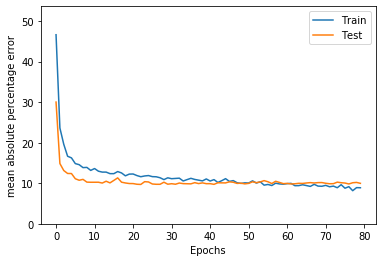

In [13]:
plt.figure()
plt.plot(epochs_list, train_losses, label='Train')
plt.plot(epochs_list, test_losses, label='Test')
plt.legend()
plt.ylim([0,1.15 * max(train_losses[0], test_losses[0])])
plt.xlabel('Epochs')
plt.ylabel('mean absolute percentage error')
plt.show()

In [17]:
model.evaluate(test_features_dict, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 9.9773 - MSLE: 0.0080


[0.008023053407669067, 9.977315902709961, 0.008023053407669067]

In [18]:
preds = model.predict(test_features_dict) * 100000
actual = test_labels * 100000

Compute the mean squared logarithmic error 

In [19]:
tot_sum = 0
for i in range(len(preds)):
    tot_sum += (np.log(preds[i] + 1) - np.log(actual[i] + 1)) ** 2
np.sqrt(tot_sum / len(preds))

array([0.141])

# New model: Random Forest

Since it seems like it will be hard to reduce our bias with a neural network, we will turn to another model: random forests. We will do the same date pre-processing, but this time using pandas, since we will Scikit learn and not keras.

In [20]:
#Do the same preprocessing as with the other model

full_data = pd.read_csv("./Data/train.csv")

year_cols=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

for col in year_cols:
    full_data[col] = full_data[col].astype(str)

cutoff = 7 * len(full_data) // 10

train_data = full_data[:cutoff]
features = train_data.copy()
labels = np.array(features.pop('SalePrice'))
features.pop('Id')

test_data = full_data[cutoff:]
test_features = test_data.copy()
test_labels = np.array(test_features.pop('SalePrice'))
test_features.pop('Id')
print()

For this we do the preprocessing only using pandas, rather than the keras layers

In [21]:
def PandasPreprocessing(features, train_data):  
    year_cols=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
    #Get years as strings
    for col in year_cols:
        train_data[col] = train_data[col].astype(str)
    #Deal with missing data as before
    for name, column in features.items():
        dtype = column.dtype
        if dtype == object:
            features[name] = features[name].fillna('NO INFO')
            train_data[name] = train_data[name].fillna('NO INFO')
            enc = OneHotEncoder(handle_unknown='ignore')
            enc.fit(train_data[name].to_numpy().reshape(-1, 1))
            encoded_col = enc.transform(column.to_numpy().reshape(-1, 1)).toarray()
            encoded_col = list(map(list, zip(*encoded_col)))
            features.pop(name)
            for i, col in enumerate(encoded_col):
                features[name + '_' + str(i)] = col
        else:
            #No real need to normalize for tree based algorithms, just fill the nans with column mean
            features[name] = features[name].fillna(features[name].mean(axis=0))
    return features

In [23]:
features = PandasPreprocessing(features, train_data)
test_features = PandasPreprocessing(test_features, train_data)

/home/mathieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
# Set values for the parameter grid we want to train our model over
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Train the model over our random grid

In [26]:
regr = RandomForestRegressor()
regr_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
regr_random.fit(features, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/mathieu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/mathieu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecate

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


Find the best parameters in the grid

In [27]:
regr_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

Evaluate the models with the optimal parameters found

In [28]:
regr = RandomForestRegressor(n_estimators = 600,
 min_samples_split = 5,
 min_samples_leaf = 1,
 max_features = 'auto',
 max_depth = 80,
 bootstrap = True)
regr.fit(features, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Evaluate the model for the test set

In [29]:
preds = regr.predict(test_features)
actual = test_labels

/home/mathieu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [30]:
tot_sum = 0
for i in range(len(preds)):
    tot_sum += (np.log(preds[i] + 1) - np.log(actual[i] + 1)) ** 2
np.sqrt(tot_sum / len(preds))

0.15025485584369982

It turns out that in this case, the RF model did not do better than the neural network